In [1]:
import pickle
import os
import sys
from statistics import mean
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
working_dir = os.getcwd()
os.chdir("../../..")
sys.path.append(os.getcwd())
from Internal_Representation.state import State
from Solver.action_tracker import ActionTracker
from runner import Runner
os.chdir(working_dir)

In [3]:
# Load pickled Object
def load_pickled_ob(file_name):
    with (open(file_name, "rb")) as openfile:
        while True:
            try:
                return pickle.load(openfile)
            except EOFError:
                break

In [4]:
# Display pickled actions_taken
def display_actions_taken(actions):
    for a in actions:
        print(a)

In [5]:
# Display pickled final state
def display_final_state(final_state):
    print(final_state)

In [78]:
size_dict = load_pickled_ob("problem_sizes.pickle")
save_graph_images = True
size_dict

{'Basic/pb1.hddl': 46,
 'Rover/p01.hddl': 483,
 'Rover/p02.hddl': 486,
 'Rover/p03.hddl': 501,
 'Rover/p04.hddl': 554,
 'Rover/p05.hddl': 633,
 'Rover/p06.hddl': 648,
 'Rover/p07.hddl': 724,
 'Depots/p01.hddl': 302,
 'Depots/p02.hddl': 330,
 'Depots/p03.hddl': 358,
 'um-translog01/problem.hddl': 1395,
 'Factories/pfile01.hddl': 219,
 'Barman/pfile01.hddl': 514}

In [7]:
class average_time:
    def __init__(self):
        self.times = {} # {'roverp0': float}
        self.num_models = {}    # {'roverp0': float}

    def calculate_average_time(self, problem_name: str, times: list) -> None:
        self.times[problem_name] = mean(times)

    def calculate_average_model(self, problem_name: str, num_models: list) -> None:
        self.num_models[problem_name] = mean(num_models)

    def get_num_models(self, problem_name: str) -> float:
        return self.num_models[problem_name]

    def __getitem__(self, item):
        return self.times[item]

In [100]:
def generate_graph(example_names: list, config_names: list, colours: list, values: list,
                   title="Average Time Taken for Solving", y_axis="Average Time Taken (Seconds)", **kwargs):
    assert len(config_names) == len(colours) == len(values)
    assert all([len(x) == len(example_names) for x in values])

    if not 'fig_size' in kwargs:
        fig_size = (18, 8)
    else:
        fig_size = kwargs['fig_size']

    plt.figure(figsize=fig_size)
    ax = plt.subplot()

    x_values = [size_dict[x] for x in example_names]

    i, l = 0, len(config_names)
    while i < l:
        y_values = [values[i][y] for y in range(len(values[i]))]
        ax.plot(x_values, y_values, 'bo-', label=r'{}'.format(config_names[i]), color=colours[i], alpha=0.6, linewidth=3)
        i += 1

    if 'xscale' in kwargs:
        plt.xscale(kwargs['xscale'])
        plt.minorticks_off()

    plt.xticks(x_values, [str(x) for x in x_values], rotation=45)
    ax.locator_params(axis='x', nbins=len(example_names))

    plt.xlabel('Problem Size'); plt.ylabel(r'{}'.format(y_axis))
    plt.title(r'{}'.format(title))
    plt.legend(loc='best')

    if save_graph_images and 'save_name' in kwargs:
        if not os.path.isdir('images'):
            os.mkdir('images')
        plt.savefig('images/' + kwargs['save_name'], dpi=500)  # Save graph to file
    plt.grid()

In [9]:
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
def significant_difference_check(list_approach_names: List[str], *args):
    """Check for statistically different data sets"""
    assert len(list_approach_names) == len(args)

    # Run shapiro test on all data
    data_values = [shapiro(x)[1] for x in args]
    data_normal = [x < 0.05 for x in data_values]

    # Assume we want to run dunn test
    run_dunn_test = True
    test_used = None

    # Run ANOVA or Kruskal test
    if all(x == False for x in data_normal):
        # Anova test
        print("All data is normally distributed")
        print("Shapiro p-values:", data_values)
        print("Non-Normal Check (False denoted non-normal):", data_normal)

        if len(list_approach_names) >= 3:
            # One-way ANOVA
            # https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
            res = f_oneway(*args)[1]
            test_used = "One-Way ANOVA"
        else:
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
            assert len(list_approach_names) == 2
            run_dunn_test = False
            res = ttest_ind(args[0], args[1])[1]
            test_used = "T-Test"
    else:
        # Kruskals test
        print("NOT FOLLOWING NORMAL DISTRIBUTION")
        print("Shapiro p-values:", data_values)
        print("Non-Normal Check (False denotes non-normal):", data_normal)
        res = kruskal(*args)[1]
        test_used = "Kruskal-Wallis"

    if res <= 0.05:
        # There is significant difference
        print("Significant Difference found ({}). P-value: {}".format(test_used, res))
    else:
        # No significant difference
        print("NO Significant Difference found ({}). P-value: {}".format(test_used, res))
        run_dunn_test = False

    # Run Dunn Test
    if run_dunn_test:
        dunns_pairwise_test(list_approach_names, *args)

In [10]:
from scikit_posthocs import posthoc_dunn

def dunns_pairwise_test(list_approach_names: List[str], *args):

    d = []
    list_approach_names_extended = []
    i = 0
    while i < len(list_approach_names):
        for j in args[i]:
            d.append(j)
            list_approach_names_extended.append(list_approach_names[i])
        i += 1

    dataFrame = pd.DataFrame(list(zip(list_approach_names_extended, d)), columns=["Heuristic_Name", "Time_Taken"])
    # print(dataFrame)

    r = posthoc_dunn(dataFrame, "Time_Taken", "Heuristic_Name", p_adjust="hommel")
    print(r)

    # Print Results
    seen_pairs = []
    for i in r.keys():
        for j in r[i].keys():
            if j + i in seen_pairs:
                continue
            seen_pairs.append(i+j)

            if r[i][j] > 0.05 and i != j:
                print("No Significant Difference: {}, {} = {}".format(i, j, r[i][j]))
            elif i == j:
                pass
            else:
                print("Significant Difference: {}, {} = {}".format(i, j, r[i][j]))

# Running operations on collected Data

## Rover p0 -> p3 with early precondition checking and without

In [11]:
"""Load data from breadth first - no early precondition checker"""
breadth_first_no_early_precon_check_data_path = os.path.join(os.getcwd(), "Archive", "rover_no_early_precon", "Breadth_First_Operations.csv")
breadth_first_no_early_precon_check = pd.read_csv(breadth_first_no_early_precon_check_data_path, sep=",")

breadth_first_no_early_precon_check_av_time = average_time()
for example_name in breadth_first_no_early_precon_check.example_name.unique():

    breadth_first_no_early_precon_check_av_time.calculate_average_time(example_name, breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['time_taken'])

    breadth_first_no_early_precon_check_av_time.calculate_average_model(example_name,                               breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == example_name]['search_models_created'])

breadth_first_no_early_precon_check

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.415648,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.413664,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.413168,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.415648,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.411184,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.047552,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.055984,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.052016,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.053008,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.064416,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [12]:
"""Load data from breadth first"""
breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Breadth_First_Operations.csv")
breadth_first = pd.read_csv(breadth_first_data_path, sep=",")

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Breadth_First_Operations.csv")
breadth_first = pd.concat([breadth_first, pd.read_csv(breadth_first_data_path, sep=",")])

breadth_first_av_time = average_time()
for example_name in breadth_first.example_name.unique():

    breadth_first_av_time.calculate_average_time(example_name, breadth_first[breadth_first['example_name'] == example_name]['time_taken'])

    breadth_first_av_time.calculate_average_model(example_name, breadth_first[breadth_first['example_name'] == example_name]['search_models_created'])

breadth_first

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.398288,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.413168,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.473184,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.400272,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.398784,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.024736,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.048048,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.033168,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.202304,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.008368,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


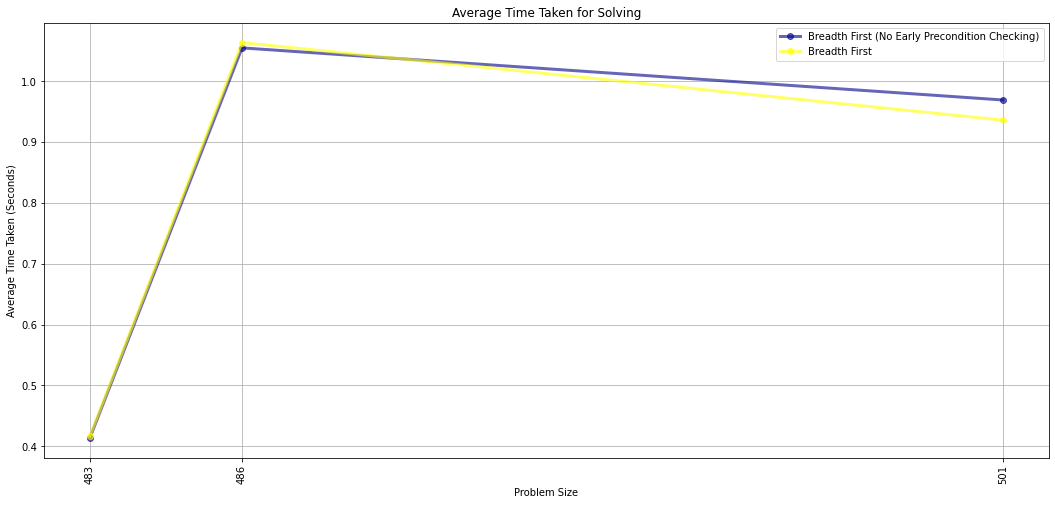

In [66]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Early Precondition Checking)", "Breadth First"], ["darkblue", "yellow"], [
[breadth_first_no_early_precon_check_av_time["Rover/p01.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p02.hddl"],
 breadth_first_no_early_precon_check_av_time["Rover/p03.hddl"]],
[breadth_first_av_time["Rover/p01.hddl"],
 breadth_first_av_time["Rover/p02.hddl"],
 breadth_first_av_time["Rover/p03.hddl"]]
])

In [14]:
# Get test times for rover p01
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p01.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p01.hddl"]['time_taken']

print("Rover p01 Statistically Significant Test")
significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

Rover p01 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.4291726052761078, 0.00681869825348258]
Non-Normal Check (False denotes non-normal): [False, True]
NO Significant Difference found (Kruskal-Wallis). P-value: 0.17452534056858016


In [15]:
# Get test times for rover p03
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p02.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p02.hddl"]['time_taken']

print("Rover p02 Statistically Significant Test")
significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

Rover p02 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.678989589214325, 0.01710452139377594]
Non-Normal Check (False denotes non-normal): [False, True]
NO Significant Difference found (Kruskal-Wallis). P-value: 0.17452534056858016


In [16]:
# Get test times for rover p03
no_precon_check = breadth_first_no_early_precon_check[breadth_first_no_early_precon_check['example_name'] == "Rover/p03.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p03.hddl"]['time_taken']

print("Rover p03 Statistically Significant Test")
significant_difference_check(["Breadth First (No Early Precondition Checking)", "Breadth First"], no_precon_check, precon_check)

Rover p03 Statistically Significant Test
All data is normally distributed
Shapiro p-values: [0.30605143308639526, 0.7950166463851929]
Non-Normal Check (False denoted non-normal): [False, False]
Significant Difference found (T-Test). P-value: 3.485058169098788e-05


## Import Remainder of data
### Breadth First
### Breadth First Pruning
### Hamming Distance
### Tree Distance
### Delete Relaxed

In [17]:
breadth_first

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.398288,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.413168,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.473184,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.400272,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.398784,2571,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,1.024736,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,1.048048,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,1.033168,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,1.202304,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,1.008368,4661,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [18]:
"""Load data from breadth first pruning"""
breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.read_csv(breadth_first_pruning_data_path, sep=",")

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Breadth_First_Operations_Pruning.csv")
breadth_first_pruning = pd.concat([breadth_first_pruning, pd.read_csv(breadth_first_pruning_data_path, sep=",")])

breadth_first_pruning_av_time = average_time()
for example_name in breadth_first_pruning.example_name.unique():
    breadth_first_pruning_av_time.calculate_average_time(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['time_taken'])

    breadth_first_pruning_av_time.calculate_average_model(example_name, breadth_first_pruning[breadth_first_pruning['example_name'] == example_name]['search_models_created'])

breadth_first_pruning

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.065968,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
1,Rover/p01.hddl,0.065968,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
2,Rover/p01.hddl,0.086304,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
3,Rover/p01.hddl,0.065968,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
4,Rover/p01.hddl,0.067456,507,serialised_objects\Rover_p01hddl_Breadth_First...,serialised_objects\Rover_p01hddl_Breadth_First...
5,Rover/p02.hddl,0.095231,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
6,Rover/p02.hddl,0.102176,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
7,Rover/p02.hddl,0.096224,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
8,Rover/p02.hddl,0.093744,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...
9,Rover/p02.hddl,0.102672,817,serialised_objects\Rover_p02hddl_Breadth_First...,serialised_objects\Rover_p02hddl_Breadth_First...


In [19]:
"""Load data for Hamming Distance"""
hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Hamming_Distance.csv")
hamming_distance = pd.read_csv(hamming_distance_data_path, sep=",")

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Hamming_Distance.csv")
hamming_distance = pd.concat([hamming_distance, pd.read_csv(hamming_distance_data_path, sep=",")])

hamming_distance_av_time = average_time()
for example_name in hamming_distance.example_name.unique():
    hamming_distance_av_time.calculate_average_time(example_name, hamming_distance[hamming_distance['example_name'] == example_name]['time_taken'])

    hamming_distance_av_time.calculate_average_model(example_name, hamming_distance[hamming_distance['example_name'] == example_name]['search_models_created'])

hamming_distance

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.043648,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
1,Rover/p01.hddl,0.034224,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
2,Rover/p01.hddl,0.034720,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
3,Rover/p01.hddl,0.034224,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
4,Rover/p01.hddl,0.034224,216,serialised_objects\Rover_p01hddl_Hamming_Dista...,serialised_objects\Rover_p01hddl_Hamming_Dista...
...,...,...,...,...,...
0,um-translog01/problem.hddl,0.107632,1289,serialised_objects\um-translog01_problemhddl_H...,serialised_objects\um-translog01_problemhddl_H...
1,um-translog01/problem.hddl,0.102176,1289,serialised_objects\um-translog01_problemhddl_H...,serialised_objects\um-translog01_problemhddl_H...
2,um-translog01/problem.hddl,0.103168,1289,serialised_objects\um-translog01_problemhddl_H...,serialised_objects\um-translog01_problemhddl_H...
3,um-translog01/problem.hddl,0.109120,1289,serialised_objects\um-translog01_problemhddl_H...,serialised_objects\um-translog01_problemhddl_H...


In [20]:
"""Load data for Tree Distance"""
tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Tree_Distance.csv")
tree_distance = pd.read_csv(tree_distance_data_path, sep=",")

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Depot", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "Factories", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Tree_Distance.csv")
tree_distance = pd.concat([tree_distance, pd.read_csv(tree_distance_data_path, sep=",")])

tree_distance_av_time = average_time()
for example_name in tree_distance.example_name.unique():
    tree_distance_av_time.calculate_average_time(example_name, tree_distance[tree_distance['example_name'] == example_name]['time_taken'])

    tree_distance_av_time.calculate_average_model(example_name, tree_distance[tree_distance['example_name'] == example_name]['search_models_created'])

tree_distance

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,0.070432,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
1,Rover/p01.hddl,0.067455,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
2,Rover/p01.hddl,0.067456,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
3,Rover/p01.hddl,0.064480,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
4,Rover/p01.hddl,0.064480,442,serialised_objects\Rover_p01hddl_Tree_Distance...,serialised_objects\Rover_p01hddl_Tree_Distance...
5,Rover/p02.hddl,0.079360,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...
6,Rover/p02.hddl,0.078368,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...
7,Rover/p02.hddl,0.077376,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...
8,Rover/p02.hddl,0.077376,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...
9,Rover/p02.hddl,0.079360,448,serialised_objects\Rover_p02hddl_Tree_Distance...,serialised_objects\Rover_p02hddl_Tree_Distance...


In [21]:
"""Load data for Delete Relaxed"""
delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Rover", "Delete_Relaxed.csv")
delete_relaxed = pd.read_csv(delete_relaxed_data_path, sep=",")

delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "Barman", "Delete_Relaxed.csv")
delete_relaxed = pd.concat([delete_relaxed, pd.read_csv(delete_relaxed_data_path, sep=",")])

delete_relaxed_data_path = os.path.join(os.getcwd(), "Archive", "translog", "Delete_Relaxed.csv")
delete_relaxed = pd.concat([delete_relaxed, pd.read_csv(delete_relaxed_data_path, sep=",")])

delete_relaxed_av_time = average_time()
for example_name in delete_relaxed.example_name.unique():
    delete_relaxed_av_time.calculate_average_time(example_name, delete_relaxed[delete_relaxed['example_name'] == example_name]['time_taken'])

    delete_relaxed_av_time.calculate_average_model(example_name, delete_relaxed[delete_relaxed['example_name'] == example_name]['search_models_created'])

delete_relaxed

,example_name,time_taken,search_models_created,serialised_actions_taken,serialised_state
0,Rover/p01.hddl,7.685025,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
1,Rover/p01.hddl,8.438448,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
2,Rover/p01.hddl,7.667168,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
3,Rover/p01.hddl,7.747025,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
4,Rover/p01.hddl,7.668160,645,serialised_objects\Rover_p01hddl_Delete_Relaxe...,serialised_objects\Rover_p01hddl_Delete_Relaxe...
0,Barman/pfile01.hddl,63.292086,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...
1,Barman/pfile01.hddl,63.556950,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...
2,Barman/pfile01.hddl,64.622856,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...
3,Barman/pfile01.hddl,62.152277,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...
4,Barman/pfile01.hddl,63.106086,20866,serialised_objects\Barman_pfile01hddl_Delete_R...,serialised_objects\Barman_pfile01hddl_Delete_R...


## Graph for All Delete Relaxed Problems (Includes all heuristics)

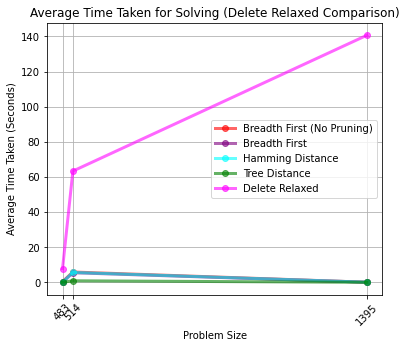

In [106]:
generate_graph(["Rover/p01.hddl", "Barman/pfile01.hddl", "um-translog01/problem.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance", "Delete Relaxed"], ["red", "purple", "aqua", "green", "magenta"],
               [
                   [breadth_first_av_time["Rover/p01.hddl"],
                    breadth_first_av_time["Barman/pfile01.hddl"],
                    breadth_first_av_time["um-translog01/problem.hddl"]],
                   [breadth_first_pruning_av_time["Rover/p01.hddl"],
                    breadth_first_pruning_av_time["Barman/pfile01.hddl"],
                    breadth_first_pruning_av_time["um-translog01/problem.hddl"]],
                   [hamming_distance_av_time["Rover/p01.hddl"],
                    hamming_distance_av_time["Barman/pfile01.hddl"],
                    hamming_distance_av_time["um-translog01/problem.hddl"]],
                   [tree_distance_av_time["Rover/p01.hddl"],
                    tree_distance_av_time["Barman/pfile01.hddl"],
                    tree_distance_av_time["um-translog01/problem.hddl"]],
                   [delete_relaxed_av_time["Rover/p01.hddl"],
                    delete_relaxed_av_time["Barman/pfile01.hddl"],
                    delete_relaxed_av_time["um-translog01/problem.hddl"]]
               ], "Average Time Taken for Solving (Delete Relaxed Comparison)", save_name='Delete_Relaxed_Time_Comp.pdf', fig_size=(6,5))

In [31]:
# Get test times for rover p01
bf = breadth_first[breadth_first['example_name'] == "Rover/p01.hddl"]['time_taken']
bf_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "Rover/p01.hddl"]['time_taken']
hamming = hamming_distance[hamming_distance['example_name'] == "Rover/p01.hddl"]['time_taken']
tree = tree_distance[tree_distance['example_name'] == "Rover/p01.hddl"]['time_taken']
deleteRelaxed = delete_relaxed[delete_relaxed['example_name'] == "Rover/p01.hddl"]['time_taken']

print("Rover p01 Statistically Significant Test")
significant_difference_check(["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance", "Delete Relaxed"], bf, bf_pruning, hamming, tree, deleteRelaxed)

Rover p01 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.00681869825348258, 0.0006400143029168248, 0.00042179631418548524, 0.31418493390083313, 0.0014344698283821344]
Non-Normal Check (False denotes non-normal): [True, True, True, False, True]
Significant Difference found (Kruskal-Wallis). P-value: 0.00020444837372750023
                            Breadth First  Breadth First (No Pruning)  \
Breadth First                    1.000000                    0.365298   
Breadth First (No Pruning)       0.365298                    1.000000   
Delete Relaxed                   0.061193                    0.565121   
Hamming Distance                 0.281007                    0.011387   
Tree Distance                    0.897397                    0.281007   

                            Delete Relaxed  Hamming Distance  Tree Distance  
Breadth First                     0.061193          0.281007       0.897397  
Breadth First (No Pruning)        0.565121 

In [32]:
# Get test times for barman p01
bf = breadth_first[breadth_first['example_name'] == "Barman/pfile01.hddl"]['time_taken']
bf_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "Barman/pfile01.hddl"]['time_taken']
hamming = hamming_distance[hamming_distance['example_name'] == "Barman/pfile01.hddl"]['time_taken']
tree = tree_distance[tree_distance['example_name'] == "Barman/pfile01.hddl"]['time_taken']
deleteRelaxed = delete_relaxed[delete_relaxed['example_name'] == "Barman/pfile01.hddl"]['time_taken']

print("Barman p0file1 Statistically Significant Test")
significant_difference_check(["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance", "Delete Relaxed"], bf, bf_pruning, hamming, tree, deleteRelaxed)

Barman p0file1 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.5256615877151489, 0.0018918727291747928, 0.05411701649427414, 0.04562100023031235, 0.875322163105011]
Non-Normal Check (False denotes non-normal): [False, True, False, True, False]
Significant Difference found (Kruskal-Wallis). P-value: 0.00047540305582840706
                            Breadth First  Breadth First (No Pruning)  \
Breadth First                    1.000000                    0.484554   
Breadth First (No Pruning)       0.484554                    1.000000   
Delete Relaxed                   0.035929                    0.381580   
Hamming Distance                 0.646072                    0.829896   
Tree Distance                    0.468653                    0.064487   

                            Delete Relaxed  Hamming Distance  Tree Distance  
Breadth First                     0.035929          0.646072       0.468653  
Breadth First (No Pruning)        0.381580  

In [33]:
# Get test times for translog
bf = breadth_first[breadth_first['example_name'] == "um-translog01/problem.hddl"]['time_taken']
bf_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "um-translog01/problem.hddl"]['time_taken']
hamming = hamming_distance[hamming_distance['example_name'] == "um-translog01/problem.hddl"]['time_taken']
tree = tree_distance[tree_distance['example_name'] == "um-translog01/problem.hddl"]['time_taken']
deleteRelaxed = delete_relaxed[delete_relaxed['example_name'] == "um-translog01/problem.hddl"]['time_taken']

print("Translog p01 Statistically Significant Test")
significant_difference_check(["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance", "Delete Relaxed"], bf, bf_pruning, hamming, tree, deleteRelaxed)

Translog p01 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.2072233259677887, 0.016983915120363235, 0.7303095459938049, 0.08325560390949249, 0.013318267650902271]
Non-Normal Check (False denotes non-normal): [False, True, False, False, True]
Significant Difference found (Kruskal-Wallis). P-value: 0.0002032402316943612
                            Breadth First  Breadth First (No Pruning)  \
Breadth First                    1.000000                    0.863490   
Breadth First (No Pruning)       0.863490                    1.000000   
Delete Relaxed                   0.065162                    0.038948   
Hamming Distance                 0.381096                    0.268611   
Tree Distance                    0.268611                    0.381096   

                            Delete Relaxed  Hamming Distance  Tree Distance  
Breadth First                     0.065162          0.381096       0.268611  
Breadth First (No Pruning)        0.038948    

## Same Graph as above with no Delete Relaxed

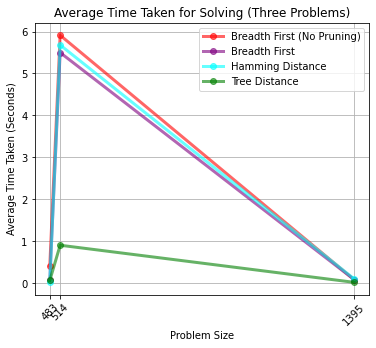

In [108]:
generate_graph(["Rover/p01.hddl", "Barman/pfile01.hddl", "um-translog01/problem.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance"], ["red", "purple", "aqua", "green"],
               [
                   [breadth_first_av_time["Rover/p01.hddl"],
                    breadth_first_av_time["Barman/pfile01.hddl"],
                    breadth_first_av_time["um-translog01/problem.hddl"]],
                   [breadth_first_pruning_av_time["Rover/p01.hddl"],
                    breadth_first_pruning_av_time["Barman/pfile01.hddl"],
                    breadth_first_pruning_av_time["um-translog01/problem.hddl"]],
                   [hamming_distance_av_time["Rover/p01.hddl"],
                    hamming_distance_av_time["Barman/pfile01.hddl"],
                    hamming_distance_av_time["um-translog01/problem.hddl"]],
                   [tree_distance_av_time["Rover/p01.hddl"],
                    tree_distance_av_time["Barman/pfile01.hddl"],
                    tree_distance_av_time["um-translog01/problem.hddl"]]
               ], "Average Time Taken for Solving (Three Problems)", save_name='Delete_Relaxed_Absent_Time_Comp.pdf', fig_size=(6,5))

## Graph for Rover p1 -> p3

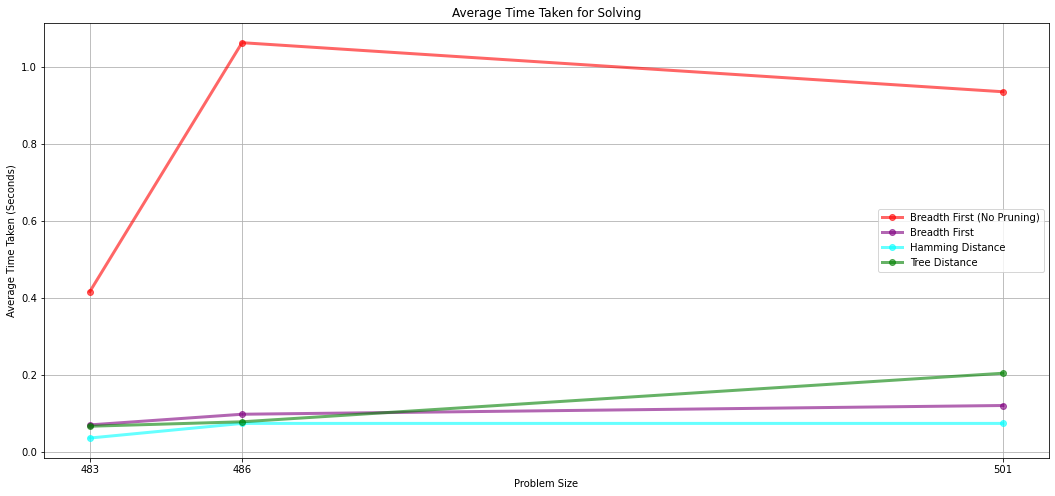

In [24]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance"], ["red", "purple", "aqua", "green"],
[
    [breadth_first_av_time["Rover/p01.hddl"],
     breadth_first_av_time["Rover/p02.hddl"],
     breadth_first_av_time["Rover/p03.hddl"]],
    [breadth_first_pruning_av_time["Rover/p01.hddl"],
     breadth_first_pruning_av_time["Rover/p02.hddl"],
     breadth_first_pruning_av_time["Rover/p03.hddl"]],
    [hamming_distance_av_time["Rover/p01.hddl"],
     hamming_distance_av_time["Rover/p02.hddl"],
     hamming_distance_av_time["Rover/p03.hddl"]],
    [tree_distance_av_time["Rover/p01.hddl"],
     tree_distance_av_time["Rover/p02.hddl"],
     tree_distance_av_time["Rover/p03.hddl"]]
])

In [50]:
# Get test times for rover p01
BF_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "Rover/p01.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p01.hddl"]['time_taken']
hamming_distance_times = hamming_distance[hamming_distance['example_name'] == "Rover/p01.hddl"]['time_taken']
tree = tree_distance[tree_distance['example_name'] == "Rover/p01.hddl"]['time_taken']

print("Rover p01 Statistically Significant Test")
significant_difference_check(["Breadth First", "Breadth First (No Pruning)", "Hamming Distance", "Tree Distance"], BF_pruning, precon_check, hamming_distance_times, tree)

Rover p01 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.0006400143029168248, 0.00681869825348258, 0.00042179631418548524, 0.31418493390083313]
Non-Normal Check (False denotes non-normal): [True, True, True, False]
Significant Difference found (Kruskal-Wallis). P-value: 0.0010708184697086319
                            Breadth First  Breadth First (No Pruning)  \
Breadth First                    1.000000                    0.108276   
Breadth First (No Pruning)       0.108276                    1.000000   
Hamming Distance                 0.081207                    0.000361   
Tree Distance                    0.872505                    0.081207   

                            Hamming Distance  Tree Distance  
Breadth First                       0.081207       0.872505  
Breadth First (No Pruning)          0.000361       0.081207  
Hamming Distance                    1.000000       0.108276  
Tree Distance                       0.108276       1.0

In [51]:
# Get test times for rover p02
BF_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "Rover/p02.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p02.hddl"]['time_taken']
hamming_distance_times = hamming_distance[hamming_distance['example_name'] == "Rover/p02.hddl"]['time_taken']
tree = tree_distance[tree_distance['example_name'] == "Rover/p02.hddl"]['time_taken']

print("Rover p02 Statistically Significant Test")
significant_difference_check(["Breadth First", "Breadth First (No Pruning)", "Hamming Distance", "Tree Distance"], BF_pruning, precon_check, hamming_distance_times, tree)

Rover p02 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.1918574422597885, 0.01710452139377594, 0.03794562816619873, 0.11860506236553192]
Non-Normal Check (False denotes non-normal): [False, True, True, False]
Significant Difference found (Kruskal-Wallis). P-value: 0.0008042892713876486
                            Breadth First  Breadth First (No Pruning)  \
Breadth First                    1.000000                    0.362570   
Breadth First (No Pruning)       0.362570                    1.000000   
Hamming Distance                 0.064468                    0.001091   
Tree Distance                    0.271928                    0.016359   

                            Hamming Distance  Tree Distance  
Breadth First                       0.064468       0.271928  
Breadth First (No Pruning)          0.001091       0.016359  
Hamming Distance                    1.000000       0.422504  
Tree Distance                       0.422504       1.000000

In [52]:
# Get test times for rover p03
BF_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "Rover/p03.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p03.hddl"]['time_taken']
hamming_distance_times = hamming_distance[hamming_distance['example_name'] == "Rover/p03.hddl"]['time_taken']
tree = tree_distance[tree_distance['example_name'] == "Rover/p03.hddl"]['time_taken']

print("Rover p03 Statistically Significant Test")
significant_difference_check(["Breadth First", "Breadth First (No Pruning)", "Hamming Distance", "Tree Distance"], BF_pruning, precon_check, hamming_distance_times, tree)

Rover p03 Statistically Significant Test
NOT FOLLOWING NORMAL DISTRIBUTION
Shapiro p-values: [0.04173586890101433, 0.7950166463851929, 0.11452962458133698, 0.0003092731349170208]
Non-Normal Check (False denotes non-normal): [True, False, False, True]
Significant Difference found (Kruskal-Wallis). P-value: 0.0004707189529993288
                            Breadth First  Breadth First (No Pruning)  \
Breadth First                    1.000000                    0.030105   
Breadth First (No Pruning)       0.030105                    1.000000   
Hamming Distance                 0.181449                    0.000366   
Tree Distance                    0.181449                    0.181449   

                            Hamming Distance  Tree Distance  
Breadth First                       0.181449       0.181449  
Breadth First (No Pruning)          0.000366       0.181449  
Hamming Distance                    1.000000       0.030105  
Tree Distance                       0.030105       1.0000

## Graph with:
### Rover p01 -> p03
### Barman p1 -> p3
### Depot p1 -> p3
### Translog
### Factories p1

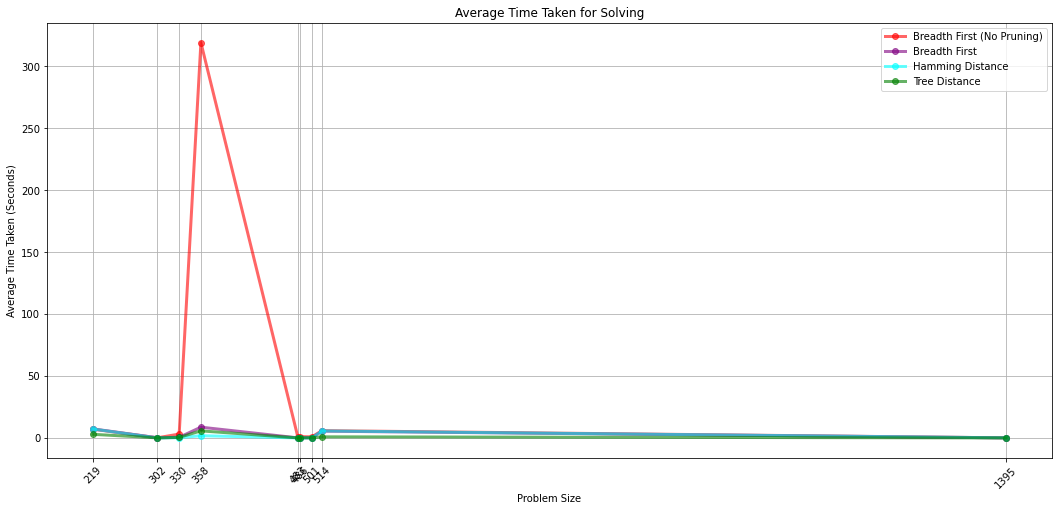

In [76]:
generate_graph(["Factories/pfile01.hddl", "Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl", "Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Barman/pfile01.hddl", "um-translog01/problem.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance"], ["red", "purple", "aqua", "green"],
               [
                   [
                       breadth_first_av_time["Factories/pfile01.hddl"],
                       breadth_first_av_time["Depots/p01.hddl"],
                       breadth_first_av_time["Depots/p02.hddl"],
                       breadth_first_av_time["Depots/p03.hddl"],
                       breadth_first_av_time["Rover/p01.hddl"],
                    breadth_first_av_time["Rover/p02.hddl"],
                    breadth_first_av_time["Rover/p03.hddl"],
                    breadth_first_av_time["Barman/pfile01.hddl"],
                    breadth_first_av_time["um-translog01/problem.hddl"]
                    ],
                   [
                       breadth_first_pruning_av_time["Factories/pfile01.hddl"],
                       breadth_first_pruning_av_time["Depots/p01.hddl"],
                       breadth_first_pruning_av_time["Depots/p02.hddl"],
                       breadth_first_pruning_av_time["Depots/p03.hddl"],
                       breadth_first_pruning_av_time["Rover/p01.hddl"],
                    breadth_first_pruning_av_time["Rover/p02.hddl"],
                    breadth_first_pruning_av_time["Rover/p03.hddl"],
                    breadth_first_pruning_av_time["Barman/pfile01.hddl"],
                    breadth_first_pruning_av_time["um-translog01/problem.hddl"]
                    ],
                   [
                       hamming_distance_av_time["Factories/pfile01.hddl"],
                       hamming_distance_av_time["Depots/p01.hddl"],
                       hamming_distance_av_time["Depots/p02.hddl"],
                       hamming_distance_av_time["Depots/p03.hddl"],
                       hamming_distance_av_time["Rover/p01.hddl"],
                    hamming_distance_av_time["Rover/p02.hddl"],
                    hamming_distance_av_time["Rover/p03.hddl"],
                    hamming_distance_av_time["Barman/pfile01.hddl"],
                    hamming_distance_av_time["um-translog01/problem.hddl"]
                    ],
                   [
                       tree_distance_av_time["Factories/pfile01.hddl"],
                       tree_distance_av_time["Depots/p01.hddl"],
                       tree_distance_av_time["Depots/p02.hddl"],
                       tree_distance_av_time["Depots/p03.hddl"],
                       tree_distance_av_time["Rover/p01.hddl"],
                    tree_distance_av_time["Rover/p02.hddl"],
                    tree_distance_av_time["Rover/p03.hddl"],
                    tree_distance_av_time["Barman/pfile01.hddl"],
                    tree_distance_av_time["um-translog01/problem.hddl"]
                    ]
               ])

## Same as above but with no tanslog

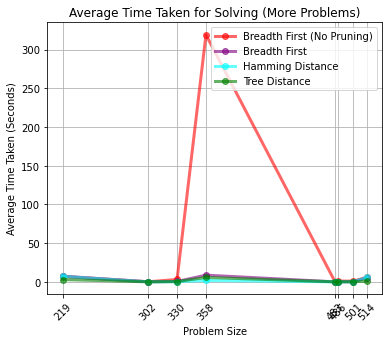

In [112]:
generate_graph(["Factories/pfile01.hddl", "Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl", "Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Barman/pfile01.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance"], ["red", "purple", "aqua", "green"],
               [
                   [
                       breadth_first_av_time["Factories/pfile01.hddl"],
                       breadth_first_av_time["Depots/p01.hddl"],
                       breadth_first_av_time["Depots/p02.hddl"],
                       breadth_first_av_time["Depots/p03.hddl"],
                       breadth_first_av_time["Rover/p01.hddl"],
                       breadth_first_av_time["Rover/p02.hddl"],
                       breadth_first_av_time["Rover/p03.hddl"],
                       breadth_first_av_time["Barman/pfile01.hddl"],
                   ],
                   [
                       breadth_first_pruning_av_time["Factories/pfile01.hddl"],
                       breadth_first_pruning_av_time["Depots/p01.hddl"],
                       breadth_first_pruning_av_time["Depots/p02.hddl"],
                       breadth_first_pruning_av_time["Depots/p03.hddl"],
                       breadth_first_pruning_av_time["Rover/p01.hddl"],
                       breadth_first_pruning_av_time["Rover/p02.hddl"],
                       breadth_first_pruning_av_time["Rover/p03.hddl"],
                       breadth_first_pruning_av_time["Barman/pfile01.hddl"],
                   ],
                   [
                       hamming_distance_av_time["Factories/pfile01.hddl"],
                       hamming_distance_av_time["Depots/p01.hddl"],
                       hamming_distance_av_time["Depots/p02.hddl"],
                       hamming_distance_av_time["Depots/p03.hddl"],
                       hamming_distance_av_time["Rover/p01.hddl"],
                       hamming_distance_av_time["Rover/p02.hddl"],
                       hamming_distance_av_time["Rover/p03.hddl"],
                       hamming_distance_av_time["Barman/pfile01.hddl"],
                   ],
                   [
                       tree_distance_av_time["Factories/pfile01.hddl"],
                       tree_distance_av_time["Depots/p01.hddl"],
                       tree_distance_av_time["Depots/p02.hddl"],
                       tree_distance_av_time["Depots/p03.hddl"],
                       tree_distance_av_time["Rover/p01.hddl"],
                       tree_distance_av_time["Rover/p02.hddl"],
                       tree_distance_av_time["Rover/p03.hddl"],
                       tree_distance_av_time["Barman/pfile01.hddl"],
                   ]
               ], "Average Time Taken for Solving (More Problems)", fig_size=(6,5))

## Same as above with rover 2 removed

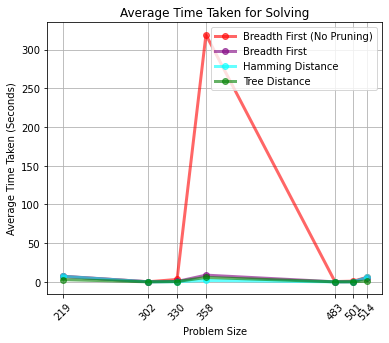

In [118]:
generate_graph(["Factories/pfile01.hddl", "Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl", "Rover/p01.hddl", "Rover/p03.hddl", "Barman/pfile01.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance"], ["red", "purple", "aqua", "green"],
               [
                   [
                       breadth_first_av_time["Factories/pfile01.hddl"],
                       breadth_first_av_time["Depots/p01.hddl"],
                       breadth_first_av_time["Depots/p02.hddl"],
                       breadth_first_av_time["Depots/p03.hddl"],
                       breadth_first_av_time["Rover/p01.hddl"],
                       breadth_first_av_time["Rover/p03.hddl"],
                       breadth_first_av_time["Barman/pfile01.hddl"],
                   ],
                   [
                       breadth_first_pruning_av_time["Factories/pfile01.hddl"],
                       breadth_first_pruning_av_time["Depots/p01.hddl"],
                       breadth_first_pruning_av_time["Depots/p02.hddl"],
                       breadth_first_pruning_av_time["Depots/p03.hddl"],
                       breadth_first_pruning_av_time["Rover/p01.hddl"],
                       breadth_first_pruning_av_time["Rover/p03.hddl"],
                       breadth_first_pruning_av_time["Barman/pfile01.hddl"],
                   ],
                   [
                       hamming_distance_av_time["Factories/pfile01.hddl"],
                       hamming_distance_av_time["Depots/p01.hddl"],
                       hamming_distance_av_time["Depots/p02.hddl"],
                       hamming_distance_av_time["Depots/p03.hddl"],
                       hamming_distance_av_time["Rover/p01.hddl"],
                       hamming_distance_av_time["Rover/p03.hddl"],
                       hamming_distance_av_time["Barman/pfile01.hddl"],
                   ],
                   [
                       tree_distance_av_time["Factories/pfile01.hddl"],
                       tree_distance_av_time["Depots/p01.hddl"],
                       tree_distance_av_time["Depots/p02.hddl"],
                       tree_distance_av_time["Depots/p03.hddl"],
                       tree_distance_av_time["Rover/p01.hddl"],
                       tree_distance_av_time["Rover/p03.hddl"],
                       tree_distance_av_time["Barman/pfile01.hddl"],
                   ]
               ], "Average Time Taken for Solving", save_name="all_problems.pdf", fig_size=(6,5))

## Same as above but with not Depot 3

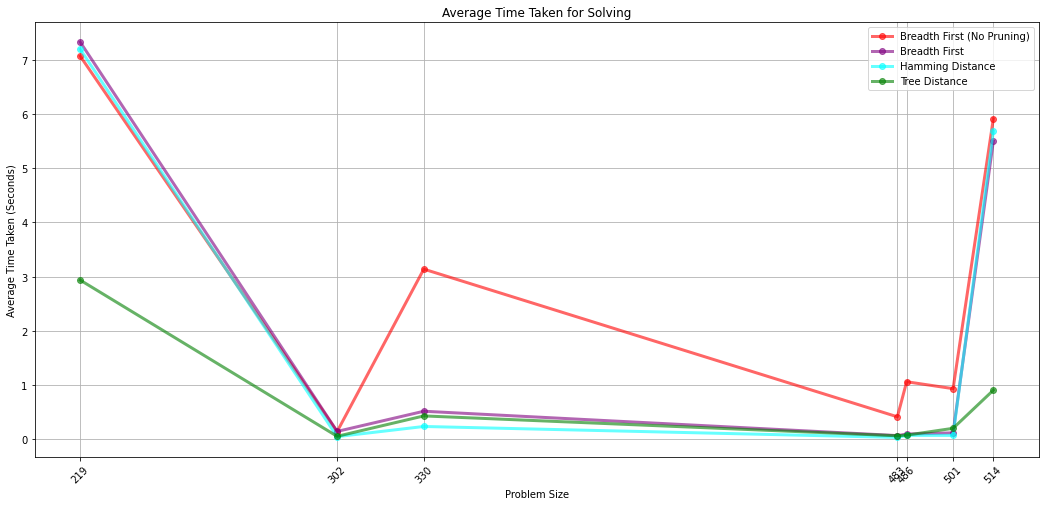

In [109]:
generate_graph(["Factories/pfile01.hddl", "Depots/p01.hddl", "Depots/p02.hddl", "Rover/p01.hddl", "Rover/p03.hddl", "Barman/pfile01.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Hamming Distance", "Tree Distance"], ["red", "purple", "aqua", "green"],
               [
                   [
                       breadth_first_av_time["Factories/pfile01.hddl"],
                       breadth_first_av_time["Depots/p01.hddl"],
                       breadth_first_av_time["Depots/p02.hddl"],
                       breadth_first_av_time["Rover/p01.hddl"],
                       breadth_first_av_time["Rover/p03.hddl"],
                       breadth_first_av_time["Barman/pfile01.hddl"]
                   ],
                   [
                       breadth_first_pruning_av_time["Factories/pfile01.hddl"],
                       breadth_first_pruning_av_time["Depots/p01.hddl"],
                       breadth_first_pruning_av_time["Depots/p02.hddl"],
                       breadth_first_pruning_av_time["Rover/p01.hddl"],
                       breadth_first_pruning_av_time["Rover/p03.hddl"],
                       breadth_first_pruning_av_time["Barman/pfile01.hddl"]
                   ],
                   [
                       hamming_distance_av_time["Factories/pfile01.hddl"],
                       hamming_distance_av_time["Depots/p01.hddl"],
                       hamming_distance_av_time["Depots/p02.hddl"],
                       hamming_distance_av_time["Rover/p01.hddl"],
                       hamming_distance_av_time["Rover/p03.hddl"],
                       hamming_distance_av_time["Barman/pfile01.hddl"]
                   ],
                   [
                       tree_distance_av_time["Factories/pfile01.hddl"],
                       tree_distance_av_time["Depots/p01.hddl"],
                       tree_distance_av_time["Depots/p02.hddl"],
                       tree_distance_av_time["Rover/p01.hddl"],
                       tree_distance_av_time["Rover/p03.hddl"],
                       tree_distance_av_time["Barman/pfile01.hddl"]
                   ]
               ])

## Same as above but with breadth first No pruning removed

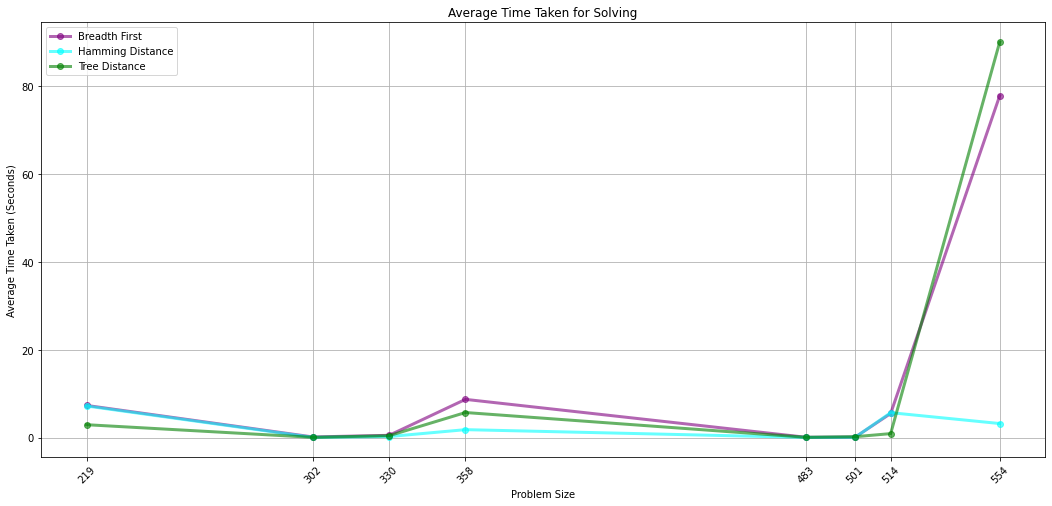

In [116]:
generate_graph(["Factories/pfile01.hddl", "Depots/p01.hddl", "Depots/p02.hddl", "Depots/p03.hddl", "Rover/p01.hddl", "Rover/p03.hddl", "Barman/pfile01.hddl", "Rover/p04.hddl"], ["Breadth First", "Hamming Distance", "Tree Distance"], ["purple", "aqua", "green"],
               [
                   [
                       breadth_first_pruning_av_time["Factories/pfile01.hddl"],
                       breadth_first_pruning_av_time["Depots/p01.hddl"],
                       breadth_first_pruning_av_time["Depots/p02.hddl"],
                       breadth_first_pruning_av_time["Depots/p03.hddl"],
                       breadth_first_pruning_av_time["Rover/p01.hddl"],
                       breadth_first_pruning_av_time["Rover/p03.hddl"],
                       breadth_first_pruning_av_time["Barman/pfile01.hddl"],
                       breadth_first_pruning_av_time["Rover/p04.hddl"]
                   ],
                   [
                       hamming_distance_av_time["Factories/pfile01.hddl"],
                       hamming_distance_av_time["Depots/p01.hddl"],
                       hamming_distance_av_time["Depots/p02.hddl"],
                       hamming_distance_av_time["Depots/p03.hddl"],
                       hamming_distance_av_time["Rover/p01.hddl"],
                       hamming_distance_av_time["Rover/p03.hddl"],
                       hamming_distance_av_time["Barman/pfile01.hddl"],
                       hamming_distance_av_time["Rover/p04.hddl"]
                   ],
                   [
                       tree_distance_av_time["Factories/pfile01.hddl"],
                       tree_distance_av_time["Depots/p01.hddl"],
                       tree_distance_av_time["Depots/p02.hddl"],
                       tree_distance_av_time["Depots/p03.hddl"],
                       tree_distance_av_time["Rover/p01.hddl"],
                       tree_distance_av_time["Rover/p03.hddl"],
                       tree_distance_av_time["Barman/pfile01.hddl"],
                       tree_distance_av_time["Rover/p04.hddl"]
                   ]
               ])

## Rover p01 -> p07 with all heuristics
For this test, the breadth first non-pruning search strategy was run for 2 hours and was not able to produce a result

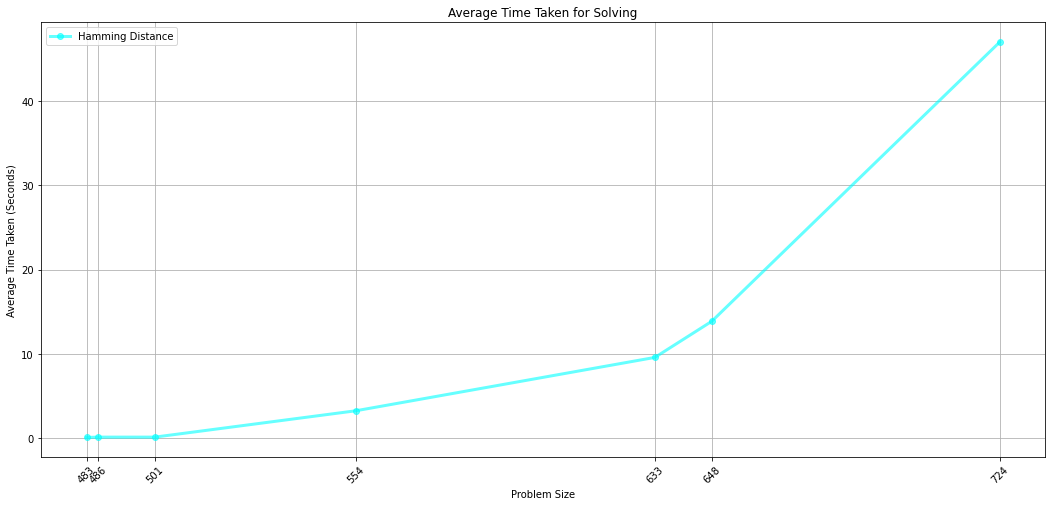

In [117]:
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl",
                "Rover/p06.hddl", "Rover/p07.hddl"],
               ["Hamming Distance"], ["aqua"],
               [
                   [hamming_distance_av_time["Rover/p01.hddl"],
                    hamming_distance_av_time["Rover/p02.hddl"],
                    hamming_distance_av_time["Rover/p03.hddl"],
                    hamming_distance_av_time["Rover/p04.hddl"],
                    hamming_distance_av_time["Rover/p05.hddl"],
                    hamming_distance_av_time["Rover/p06.hddl"],
                    hamming_distance_av_time["Rover/p07.hddl"]]
               ])

## Depot 1 -> 3 with all heuristics

'Stats Tests'

# Graph number of models created during search

## Rover p0 -> p3. Breadth first, breadth first with pruning, predicate distance to goal

In [30]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Predicate Distance To Goal Heuristic"], ["red", "purple", "aqua"],
               [
                   [breadth_first_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p03.hddl")],
                   [breadth_first_pruning_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p03.hddl")],
                   [predicate_distance_to_goal_av_time.get_num_models("Rover/p01.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p02.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p03.hddl")]
               ], "Amount of Models Created During Search", "Number of Models")

NameError: name 'predicate_distance_to_goal_av_time' is not defined

In [ ]:
# Get test times for rover p03
BF_pruning = breadth_first_pruning[breadth_first_pruning['example_name'] == "Rover/p03.hddl"]['time_taken']
precon_check = breadth_first[breadth_first['example_name'] == "Rover/p03.hddl"]['time_taken']
hamming_distance_times = hamming_distance[hamming_distance['example_name'] == "Rover/p03.hddl"]['time_taken']

print("Rover p03 Statistically Significant Test")
significant_difference_check(["Breadth First", "Breadth First (No Pruning)", "Hamming Distance"], BF_pruning, precon_check, hamming_distance_times)

## Graph with:
### Rover

## Rover p01 -> p07 pruning and predicate_distance
For this test, the breadth first non-pruning search strategy was run for 2 hours and was not able to produce a result

In [ ]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl", "Rover/p04.hddl", "Rover/p05.hddl",
                "Rover/p06.hddl", "Rover/p07.hddl"],
               ["Hamming Distance"], ["aqua"],
               [
                   [hamming_distance_av_time["Rover/p01.hddl"],
                    hamming_distance_av_time["Rover/p02.hddl"],
                    hamming_distance_av_time["Rover/p03.hddl"],
                    hamming_distance_av_time["Rover/p04.hddl"],
                    hamming_distance_av_time["Rover/p05.hddl"],
                    hamming_distance_av_time["Rover/p06.hddl"],
                    hamming_distance_av_time["Rover/p07.hddl"]]
               ])

In [ ]:
"""Stats Tests"""

# Graph number of models created during search

## Rover p0 -> p3. Breadth first, breadth first with pruning, predicate distance to goal

In [ ]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Predicate Distance To Goal Heuristic"], ["red", "purple", "aqua"],
               [
                   [breadth_first_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p03.hddl")],
                   [breadth_first_pruning_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p03.hddl")],
                   [predicate_distance_to_goal_av_time.get_num_models("Rover/p01.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p02.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p03.hddl")]
               ], "Amount of Models Created During Search", "Number of Models")

# Graph number of models created during search

## Rover p0 -> p3. Breadth first, breadth first with pruning, predicate distance to goal

In [ ]:
"""Create Graph"""
generate_graph(["Rover/p01.hddl", "Rover/p02.hddl", "Rover/p03.hddl"], ["Breadth First (No Pruning)", "Breadth First", "Predicate Distance To Goal Heuristic"], ["red", "purple", "aqua"],
               [
                   [breadth_first_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_av_time.get_num_models("Rover/p03.hddl")],
                   [breadth_first_pruning_av_time.get_num_models("Rover/p01.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p02.hddl"),
                    breadth_first_pruning_av_time.get_num_models("Rover/p03.hddl")],
                   [predicate_distance_to_goal_av_time.get_num_models("Rover/p01.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p02.hddl"),
                    predicate_distance_to_goal_av_time.get_num_models("Rover/p03.hddl")]
               ], "Amount of Models Created During Search", "Number of Models")

# Area for checking serialised files

In [ ]:
file_name = predicate_distance_to_goal.iloc[0]['serialised_actions_taken']
actions_taken = load_pickled_ob(file_name)
display_actions_taken(actions_taken)

In [ ]:
file_name = predicate_distance_to_goal.iloc[0]['serialised_state']
final_state = load_pickled_ob(file_name)
display_final_state(final_state)